In [3]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [4]:
# Insert local path to MAVE-NN at beginning of Python's path
import sys
sys.path.insert(0, '/Users/annzhu/Desktop/phillipslab/mavenn')

#Load mavenn
import mavenn

In [18]:
# Choose dataset
data_name = 'WaaA-coaD'

print(f"Loading dataset '{data_name}' ")

# Load datset
_data_df = pd.read_csv('/Users/annzhu/Desktop/phillipslab/LB_data.csv')
data_df = _data_df[_data_df['gene'].str.contains('WaaA-coaD')]
data_df = data_df.dropna()
print(len(data_df))


df_bin = pd.DataFrame()

for i in range(len(data_df)):
    ct0, ct1, seq = data_df.iloc[i][['counts_DNA', 'counts_RNA', 'seq']]
    df_ct0 = pd.DataFrame(
        data={
            "ct_0":np.ones(int(ct0)), 
            "ct_1":np.zeros(int(ct0)), 
            "seq":np.full(int(ct0), seq)})
    df_ct1 = pd.DataFrame(
        data={
            "ct_0":np.zeros(int(ct1)), 
            "ct_1":np.ones(int(ct1)), 
            "seq":np.full(int(ct1), seq)})
    df_bin = pd.concat([df_bin, df_ct0, df_ct1])
    
df_bin.reset_index(inplace=True, drop=True)
# df_bin['seq'] = [x[:160] for x in df_bin['seq']]

# Add random set classification: test/training/validation
set_options = ['test', 'training', 'validation']
vals = random.choices(population=set_options, weights=[0.2, 0.6, 0.2], k=len(df_bin))

df_bin.insert(loc=0,
column='set',
value=vals)

# m = data_df['set'].eq('Placeholder')
# data_df.loc[m, 'set'] = np.random.choice(set_options, size=m.sum())

# Get and report sequence length
L = len(df_bin.loc[0, 'seq'])
print(f'Sequence length: {L:d} amino acids')
               
# Preview dataset
df_bin

Loading dataset 'WaaA-coaD' 
708
Sequence length: 160 amino acids


,set,ct_0,ct_1,seq
0,validation,1.0,0.0,ACAAACACAAAAGAAATGAATATGTAGCGGAAGGTCAGACCAAACT...
1,training,1.0,0.0,ACAAACACAAAAGAAATGAATATGTAGCGGAAGGTCAGACCAAACT...
2,validation,1.0,0.0,ACAAACACAAAAGAAATGAATATGTAGCGGAAGGTCAGACCAAACT...
3,training,1.0,0.0,ACAAACACAAAAGAAATGAATATGTAGCGGAAGGTCAGACCAAACT...
4,training,1.0,0.0,ACAAACACAAAAGAAATGAATATGTAGCGGAAGGTCAGACCAAACT...
...,...,...,...,...
45756,validation,1.0,0.0,AAAAAAACAAAAAAAATGAAGATGTAGCGCCAGGTCAGACCAACCT...
45757,training,1.0,0.0,AAAAAAACAAAAAAAATGAAGATGTAGCGCCAGGTCAGACCAACCT...
45758,training,1.0,0.0,AAAAAAACAAAAAAAATGAAGATGTAGCGCCAGGTCAGACCAACCT...
45759,validation,1.0,0.0,AAAAAAACAAAAAAAATGAAGATGTAGCGCCAGGTCAGACCAACCT...


In [6]:
# Split dataset
trainval_df, test_df = mavenn.split_dataset(df_bin)

# Show dataset sizes
print(f'Train + val set size : {len(trainval_df):6,d} observations')
print(f'Test set size        : {len(test_df):6,d} observations')

# Preview trainval_df
trainval_df

Training set   :   27,561 observations (  60.23%)
Validation set :    9,111 observations (  19.91%)
Test set       :    9,089 observations (  19.86%)
-------------------------------------------------
Total dataset  :   45,761 observations ( 100.00%)

Train + val set size : 36,672 observations
Test set size        :  9,089 observations


,validation,ct_0,ct_1,seq
0,True,1.0,0.0,ACAAACACAAAAGAAATGAATATGTAGCGGAAGGTCAGACCAAACT...
1,True,1.0,0.0,ACAAACACAAAAGAAATGAATATGTAGCGGAAGGTCAGACCAAACT...
2,False,1.0,0.0,ACAAACACAAAAGAAATGAATATGTAGCGGAAGGTCAGACCAAACT...
3,False,1.0,0.0,ACAAACACAAAAGAAATGAATATGTAGCGGAAGGTCAGACCAAACT...
4,False,1.0,0.0,ACAAACACAAAAGAAATGAATATGTAGCGGAAGGTCAGACCAAACT...
...,...,...,...,...
36667,True,1.0,0.0,AAAAAAACAAAAAAAATGAAGATGTAGCGCCAGGTCAGACCAACCT...
36668,False,1.0,0.0,AAAAAAACAAAAAAAATGAAGATGTAGCGCCAGGTCAGACCAACCT...
36669,False,1.0,0.0,AAAAAAACAAAAAAAATGAAGATGTAGCGCCAGGTCAGACCAACCT...
36670,False,1.0,0.0,AAAAAAACAAAAAAAATGAAGATGTAGCGCCAGGTCAGACCAACCT...


In [7]:
# Get the length of the sequence
L = len(df_bin['seq'][0])
# Get the column index for the counts
y_cols = trainval_df.columns[1:-1]
# Get the number of count columns
len_y_cols = len(y_cols)

In [8]:
from mavenn.src.layers.gpmap import GPMapLayer

# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant

class ThermodynamicLayer(GPMapLayer):
    """
    Represents a three-stage thermodynamic model
    containing the states:
    1. free DNA
    2. YieP-DNA binding
    3. RNAP-DNA binding
    """

    def __init__(self,
                 tf_start,
                 tf_end,
                 rnap_start,
                 rnap_end,
                 *args, **kwargs):
        """Construct layer instance."""

        # Call superclass
        super().__init__(*args, **kwargs)

        # set attributes
        self.tf_start = tf_start             # transcription factor starting position
        self.tf_end = tf_end                 # transcription factor ending position
        self.L_tf = tf_end - tf_start        # length of transcription factor
        self.rnap_start = rnap_start         # RNAP starting position
        self.rnap_end = rnap_end             # RNAP ending position
        self.L_rnap = rnap_end - rnap_start  # length of RNAP

        # define bias/chemical potential weight for TF/CRP energy
        self.theta_tf_0 = self.add_weight(name='theta_tf_0',
                                          shape=(1,),
                                          initializer=Constant(1.),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # define bias/chemical potential weight for rnap energy
        self.theta_rnap_0 = self.add_weight(name='theta_rnap_0',
                                            shape=(1,),
                                            initializer=Constant(1.),
                                            trainable=True,
                                            regularizer=self.regularizer)

        # initialize the theta_tf
        theta_tf_shape = (1, self.L_tf, self.C)
        theta_tf_init = np.random.randn(*theta_tf_shape)/np.sqrt(self.L_tf)

        # define the weights of the layer corresponds to theta_tf
        self.theta_tf = self.add_weight(name='theta_tf',
                                        shape=theta_tf_shape,
                                        initializer=Constant(theta_tf_init),
                                        trainable=True,
                                        regularizer=self.regularizer)

        # define theta_rnap parameters
        theta_rnap_shape = (1, self.L_rnap, self.C)
        theta_rnap_init = np.random.randn(*theta_rnap_shape)/np.sqrt(self.L_rnap)

        # define the weights of the layer corresponds to theta_rnap
        self.theta_rnap = self.add_weight(name='theta_rnap',
                                          shape=theta_rnap_shape,
                                          initializer=Constant(theta_rnap_init),
                                          trainable=True,
                                          regularizer=self.regularizer)


    def call(self, x):
        """Process layer input and return output.

        x: (tensor)
            Input tensor that represents one-hot encoded
            sequence values.
        """

        # extract locations of binding sites from entire lac-promoter sequence.
        # for transcription factor and rnap
        x_tf = x[:, self.C * self.tf_start:self.C * self.tf_end]
        x_rnap = x[:, self.C * self.rnap_start: self.C * self.rnap_end]

        # reshape according to tf and rnap lengths.
        x_tf = tf.reshape(x_tf, [-1, self.L_tf, self.C])
        x_rnap = tf.reshape(x_rnap, [-1, self.L_rnap, self.C])

        # compute delta G for crp binding
        G_C = self.theta_tf_0 + \
            tf.reshape(K.sum(self.theta_tf * x_tf, axis=[1, 2]),
                       shape=[-1, 1])

        # compute delta G for rnap binding
        G_R = self.theta_rnap_0 + \
            tf.reshape(K.sum(self.theta_rnap * x_rnap, axis=[1, 2]),
                       shape=[-1, 1])

        # compute phi
        numerator_of_rate = K.exp(-G_R)
        denom_of_rate = 1.0 + K.exp(-G_C) + K.exp(-G_R)
        phi = numerator_of_rate/denom_of_rate

        return phi

In [9]:
# define custom gp_map parameters dictionary
gpmap_kwargs = {'tf_start': -53+115,  # starting position of the YieP -35
                'tf_end': -39+115,  # ending position of the YieP -20
                'rnap_start': -39+115,  # starting position of the RNAP -67
                'rnap_end': 3+115,   # ending position of the RNAP -44
                'L': L,
                'C': 4,
                'theta_regularization': 0.1}

# Create model
model = mavenn.Model(L=L,
                     Y=len_y_cols,
                     alphabet='dna',
                     regression_type='MPA',
                     gpmap_type='custom',
                     gpmap_kwargs=gpmap_kwargs,
                     custom_gpmap=ThermodynamicLayer);

# Set training data
model.set_data(x=trainval_df['seq'],
               y=trainval_df[y_cols],
               validation_flags=trainval_df['validation'],
               shuffle=True);

# Fit model to data
model.fit(learning_rate=5e-4,
          epochs=2000,
          batch_size=100,
          early_stopping=True,
          early_stopping_patience=25,
          linear_initialization=False,
          verbose=False);

N = 36,672 observations set as training data.
Using 24.8% for validation.
Data shuffled.
Time to set data: 0.715 sec.
Training time: 420.0 seconds


In [11]:
model.save('WaaA-coaD_thermodynamic_mpa')

Model saved to these files:
	WaaA-coaD_thermodynamic_mpa.pickle
	WaaA-coaD_thermodynamic_mpa.h5


In [12]:
# Compute predictive information on test data
I_pred, dI_pred = model.I_predictive(x=test_df['seq'], y=test_df[y_cols])
print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

test_I_pred: 0.169 +- 0.010 bits


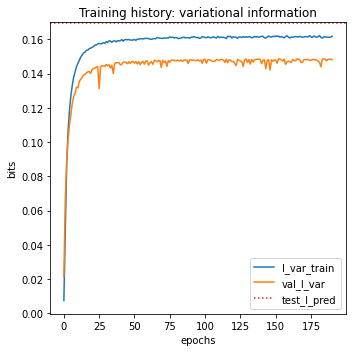

In [13]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=[5, 5])

# Plot I_var_train, the variational information on training data as a function of epoch
ax.plot(model.history['I_var'], label=r'I_var_train')

# Plot I_var_val, the variational information on validation data as a function of epoch
ax.plot(model.history['val_I_var'], label=r'val_I_var')

# Show I_pred_test, the predictive information of the final model on test data
ax.axhline(I_pred, color='C3', linestyle=':', label=r'test_I_pred')

# Style plot
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('Training history: variational information')
ax.legend()

plt.tight_layout()

In [14]:
# Get the trained model parameters
# Retrieve G-P map parameter dict and view dict keys
param_dict = model.layer_gpmap.get_params()
param_dict.keys()

dict_keys(['theta_tf_0', 'theta_rnap_0', 'theta_tf', 'theta_rnap'])

In [13]:
# delta_G_I = param_dict['theta_dG_I']  # Gibbs energy of Interaction (scalar)
# print(f'YieP-RNAP interaction energy = {delta_G_I*0.62:.3f} k_cal/mol')

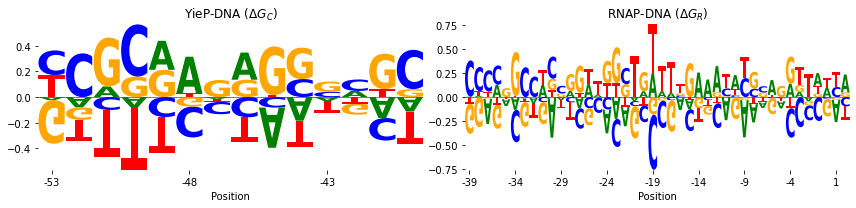

In [15]:
# import logomaker
import logomaker

# Get the \Delta G_C trained values (theta_tf)
tf_weights = param_dict['theta_tf']
# Get the \Delta G_R trained values (theta_rnap)
rnap_weights = param_dict['theta_rnap']
# Convert them to pandas dataframe
tf_df = pd.DataFrame(tf_weights, columns=model.alphabet)
rnap_df = pd.DataFrame(rnap_weights, columns=model.alphabet)


# plot logos
fig, axs = plt.subplots(1, 2, figsize=[12, 3])

# sequence logo for the YieP-DNA binding energy matrix
logo = logomaker.Logo(tf_df,  ax=axs[0], center_values=True)
axs[0].set_title('YieP-DNA ($\Delta G_C$)')
axs[0].set_xlabel('Position')
axs[0].set_xticks(np.arange(0, len(tf_weights), step=5))
axs[0].set_xticklabels(np.arange(-53, -39+1, step=5))
logo.style_spines(visible=False)


# sequence logo for the RNAP-DNA binding energy matrix
logo = logomaker.Logo(rnap_df, ax=axs[1], center_values=True)
axs[1].set_title('RNAP-DNA ($\Delta G_R$)')
axs[1].set_xlabel('Position')
axs[1].set_xticks(np.arange(0, len(rnap_weights), step=5))
axs[1].set_xticklabels(np.arange(-39, 3+1, step=5))
logo.style_spines(visible=False)

plt.tight_layout()

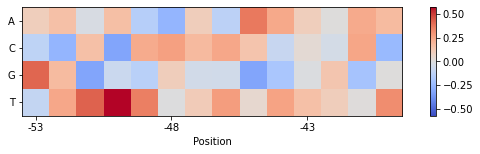

In [16]:
maximum = np.max(np.abs(tf_weights))
fig,ax = plt.subplots(figsize=((10,2)))
plt.imshow(-np.transpose(tf_weights), origin='upper', cmap='coolwarm', vmax=maximum, vmin=-maximum)
plt.xlabel('Position')
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['A','C','G','T'])
ax.set_xticks(np.arange(0, len(tf_weights), step=5))
ax.set_xticklabels(np.arange(-53, -39+1, step=5))
ax.grid(False)
plt.colorbar()

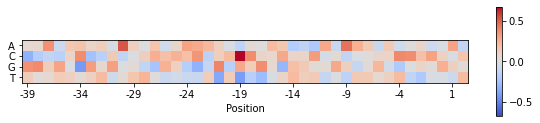

In [17]:
maximum = np.max(np.abs(rnap_weights))
fig,ax = plt.subplots(figsize=((10,2)))
plt.imshow(-np.transpose(rnap_weights), origin='upper', cmap='coolwarm', vmax=maximum, vmin=-maximum)
plt.xlabel('Position')
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['A','C','G','T'])
ax.set_xticks(np.arange(0, len(rnap_weights), step=5))
ax.set_xticklabels(np.arange(-39, 3+1, step=5))
ax.grid(False)
plt.colorbar()